# 1. Classifying different pictures

We first define the libraries needed for this first stage.

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms

%matplotlib inline
import matplotlib.pyplot as plt
import time
import os
import copy

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

plt.ion()   # interactive mode

We import the database from _Google Drive_.

In [ ]:
#Mount Google Drive as folder
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/dataHP.zip -d /content/dataHP

To approach this first part of the Challenge, I will be using Transfer Learning with a CNN as a fixed feature extractor. To do so, I will first load a pretrained network (in this case, I have chosen the _Resnet18_). Then, I will freeze the weights for all of the network except for the final fully connected layer. This last fully connected layer will be replaced by a new one with random weights and only this layer will be trained.

We first load the data and perform a normalization of the images of the database with some data augmentation based on center crops. The crops will help the network to capture better the noise and the texture of the different types of documents and it will generalize better.

In [ ]:
data_transforms = {
       'train': transforms.Compose([
        transforms.Resize(256),       # Resize the short side of the image to 150 keeping aspect ratio
        transforms.CenterCrop(256),   # Crop a square in the center of the image
        transforms.ToTensor(),        # Convert the image to a tensor with pixels in the range [0, 1]
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),       # Resize the short side of the image to 150 keeping aspect ratio
        transforms.CenterCrop(256),   # Crop a square in the center of the image
        transforms.ToTensor(),        # Convert the image to a tensor with pixels in the range [0, 1]
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

We split the data in the _training_ and _testing_ subsets and we visualize the different classes. 

In [ ]:
data_dir = '/content/dataHP'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)

['Documents', 'Plans', 'Tickets']


We define the following function to show some of the images used to train this last layer of the network, as well as their corresponding classes (Ground Truth).

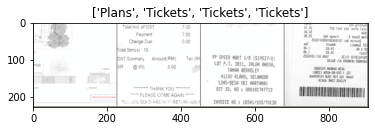

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

We also define a function to train the model. In this case, we will train the model for a fixed number of epochs storing at the end of each epoch both the training and the testing accuracy. The training will stop either when all the epochs have been computed (and then we will pick the weigths of the epoch with higher accuracy) or if the desired accuracy has been reached. We define the desired accuracy at 0.99999 $\sim$ 1.

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    terminator = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                if epoch_acc > 0.99999:
                  terminator = 1
                  break
        print()
        if terminator == 1:
          print("Desired accuracy reached!")
          break

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Finally, we also define a function for making predictions of concrete images extracted from the testing dataset.

In [ ]:
def visualize_model(model, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finally, we also define a function for the evaluation of the model by means of the _Confusion Matrix_.

In [ ]:
def compute_confunsion_matrix(model, dataloader, state):
  y_pred = []
  y_true = []
  with torch.no_grad():
      for inputs, labels in dataloader:
        
          inputs, labels = inputs.to(device), labels.to(device)

          output = model(inputs)
          output = (torch.max(output, 1)[1]).data.cpu().numpy()
          y_pred.extend(output) #save prediction

          labels =labels.data.cpu().numpy()
          y_true.extend(labels)   #save truth

  print("Train set classification report\n")
  print(classification_report(y_true, y_pred))

  cm = confusion_matrix(y_true,y_pred,normalize='true')
  display = ConfusionMatrixDisplay(cm, display_labels=class_names)

  fig, ax = plt.subplots(figsize=(3,3))
  display.plot(ax=ax, values_format='.2f')
  fig.suptitle('Normalized Confusion matrix ' + str(state) + ' set')
  return plt.show()

Here we load the pre-trained network and freeze all the layers except for the last one. We define this last fully connected layer as a layer with 3 neurons (one neuron for each of the classes).

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 3)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

We start the actual training of the model:

In [ ]:
model_conv_wout_horizontalflips = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.2585 Acc: 0.9042
val Loss: 0.0301 Acc: 0.9944

Epoch 1/24
----------
train Loss: 0.2427 Acc: 0.9056
val Loss: 0.0421 Acc: 0.9889

Epoch 2/24
----------
train Loss: 0.2756 Acc: 0.9056
val Loss: 0.0196 Acc: 0.9944

Epoch 3/24
----------
train Loss: 0.2281 Acc: 0.9070
val Loss: 0.0215 Acc: 0.9963

Epoch 4/24
----------
train Loss: 0.2422 Acc: 0.9085
val Loss: 0.0279 Acc: 0.9926

Epoch 5/24
----------
train Loss: 0.2596 Acc: 0.9028
val Loss: 0.0610 Acc: 0.9815

Epoch 6/24
----------
train Loss: 0.2615 Acc: 0.9021
val Loss: 0.0267 Acc: 0.9963

Epoch 7/24
----------
train Loss: 0.2904 Acc: 0.8993
val Loss: 0.0599 Acc: 0.9815

Epoch 8/24
----------
train Loss: 0.2356 Acc: 0.9204
val Loss: 0.0391 Acc: 0.9889

Epoch 9/24
----------
train Loss: 0.2745 Acc: 0.8930
val Loss: 0.0420 Acc: 0.9889

Epoch 10/24
----------
train Loss: 0.2816 Acc: 0.8965
val Loss: 0.0302 Acc: 0.9944

Epoch 11/24
----------
train Loss: 0.2412 Acc: 0.9134
val Loss: 0.0423 Acc: 0.9889

Ep

Once the training is finished, we can compute the _Confunsion Matrix_ for both the training and the testing sets. For the training one:

Train set classification report

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       344
           1       0.99      0.99      0.99       606
           2       0.98      0.99      0.98       470

    accuracy                           0.99      1420
   macro avg       0.99      0.99      0.99      1420
weighted avg       0.99      0.99      0.99      1420



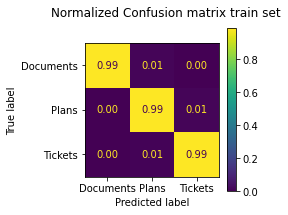

In [ ]:
compute_confunsion_matrix(model_conv_wout_horizontalflips, dataloaders['train'], "train")

For the testing one:

Train set classification report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       181
           1       0.99      1.00      1.00       203
           2       1.00      0.99      0.99       156

    accuracy                           1.00       540
   macro avg       1.00      1.00      1.00       540
weighted avg       1.00      1.00      1.00       540



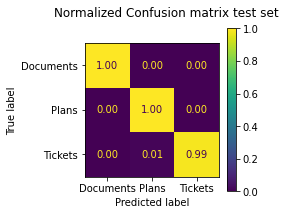

In [ ]:
compute_confunsion_matrix(model_conv_wout_horizontalflips, dataloaders['val'], "test")

Finally, we can make some predictions.

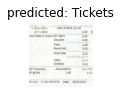

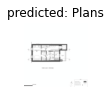

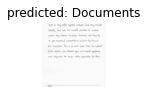

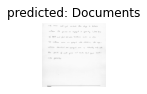

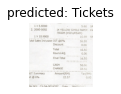

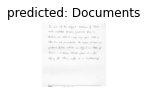

In [ ]:
visualize_model(model_conv, 6)

plt.ioff()
plt.show()

As can observe, the predictions above are correct (we can see it also by printing the Ground Truth labels) and we are obtaining pretty good accuracy for both the training and the testing phases.